In [107]:
%load_ext lab_black

In [1]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 72, number of threads: 6, number of workers: 12


In [2]:
client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
client

/work/mh0727/m300524/miniconda3/envs/pymistral/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:33686' processes=12 threads=72, memory=797.25 GB>

# Intake to load CMIP data

### Using intake-esm on mistral
- install intake-esm: https://intake-esm.readthedocs.io/en/latest/installation.html
- check the already built catalogs: `/work/ik1017/Catalogs/` or `https://github.com/NCAR/intake-esm-datastore/` and skip long catalog building process of running the builder

In [3]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import pprint
warnings.simplefilter("ignore")
%matplotlib inline
xr.set_options(keep_attrs=True)
import intake_esm
import pymistral
import cartopy.crs as ccrs
from climpred.stats import dpp, varweighted_mean_period
cmip6_post = '/work/mh0727/m300524/DCPP_post'

Read df from path: /home/mpim/m300524/pymistral/MPI-ESM-1-2-LR_output.csv


In [4]:
intake_esm.__version__

'2020.3.16.2'

Credits to Julius Busecke for creating `cmip6_preprocessing`: https://github.com/jbusecke/cmip6_preprocessing

In [5]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
##combined_preprocessing??

# CMIP6

In [6]:
col_url = "/work/ik1017/Catalogs//mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [116]:
col.search(experiment_id="dcppA-hindcast").df.variable_id.unique()

array(['zooc', 'talk', 'dissic', 'deptho', 'thkcello', 'sftof',
       'areacello', 'orog', 'areacella', 'tsl', 'cVeg', 'cRoot', 'mrso',
       'lai', 'nbp', 'rh', 'opottemppmdiff', 'rsdoabsorb', 'fgco2nat',
       'opottempdiff', 'diftrblo', 'difvso', 'dissicnat', 'difvho',
       'somint', 'sftgif', 'rsdt', 'tas', 'ta', 'hus', 'rsdscs', 'prw',
       'tasmin', 'sos', 'so', 'vo', 'tauvo', 'zostoga', 'snm', 'mrro',
       'mrros', 'od550aer', 'abs550aer', 'phyc', 'fgco2', 'dissicabio',
       'pon', 'no3', 'detoc', 'opottemprmadvect', 'osalttend', 'sftlf',
       'zg', 'tasmax', 'hfss', 'rsds', 'va', 'clt', 'rsus', 'hfds', 'umo',
       'o2', 'msftbarot', 'tauuo', 'snd', 'mrsos', 'fLitterSoil', 'prveg',
       'grassFrac', 'ra', 'nppLeaf', 'nppRoot', 'wetbc', 'wetso2',
       'od550csaer', 'drydust', 'dryso2', 'lwp', 'ps', 'od550ss',
       'nppStem', 'vegFrac', 'mrlso', 'treeFracBdlEvg',
       'fVegLitterSenescence', 'netAtmosLandCO2Flux', 'treeFracNdlDcd',
       'mrsll', 'treeFracB

## select variable

In [114]:
variable = "tas"
table_id = "Amon"

In [108]:
variable = "fgco2"
table_id = "Omon"

In [115]:
variable = "tos"
table_id = "Omon"

### hindcast and assimilation available

In [117]:
query = dict(
    experiment_id=["dcppA-hindcast", "dcppA-assim"],
    table_id=table_id,
    variable_id=variable,
    require_all_on="source_id",
)
cat = col.search(**query)

print(cat.df["source_id"].unique())

[]


## hindcast complete

In [118]:
cat_hind = col.search(
    experiment_id="dcppA-hindcast", table_id=table_id, variable_id=variable
)
cat_hind.df.source_id.unique()

array(['CanESM5', 'BCC-CSM2-MR', 'MPI-ESM1-2-HR', 'NorCPM1'], dtype=object)

In [119]:
def hindcast_complete(cat_hind):
    assert (
        len(cat_hind.df.source_id.unique()) == 1
    ), "please provide cat_hind with only one unique source_id"
    nmember = len(cat_hind.df.member_id.unique())
    ninit = len(cat_hind.df.dcpp_init_year.unique())
    print(
        f"Member: {nmember} and Inits: {ninit}: expected {nmember*ninit} files vs found {cat_hind.df.index.size} files"
    )
    if nmember * ninit > cat_hind.df.index.size:
        plot_xinit_ymember(cat_hind)
        return False
    else:
        print("success")
        return True

In [120]:
def plot_xinit_ymember(cat):
    assert (
        len(cat.df.source_id.unique()) == 1
    ), "please provide cat_hind with only one unique source_id"
    maxmember = cat.df.member_id.unique().size
    plt.axhline(y=maxmember, c="gray", ls="--", label="Total available")
    cat.df[["dcpp_init_year", "member_id"]].groupby("dcpp_init_year").count().plot(
        label="downloaded", ax=plt.gca()
    )
    plt.ylabel("# Member")
    titlestr = (
        f"model {cat.df.source_id.unique()}, variable {cat.df.variable_id.unique()}"
    )
    plt.title(titlestr)
    plt.legend()
    plt.show()

Member: 10 and Inits: 57: expected 570 files vs found 230 files


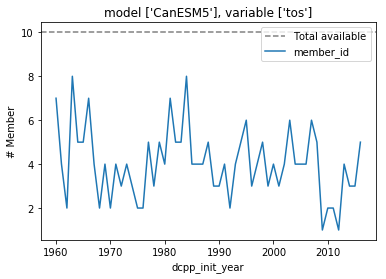


 CanESM5 completely downloaded: False
Member: 8 and Inits: 17: expected 136 files vs found 128 files


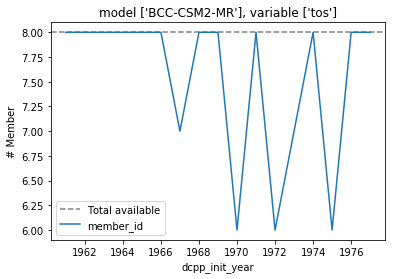


 BCC-CSM2-MR completely downloaded: False
Member: 5 and Inits: 59: expected 295 files vs found 295 files
success

 MPI-ESM1-2-HR completely downloaded: True
Member: 20 and Inits: 59: expected 1180 files vs found 375 files


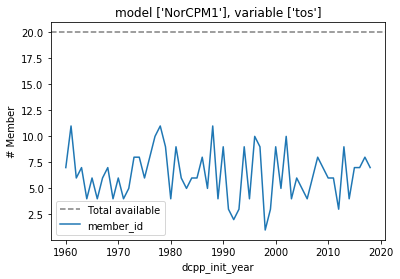


 NorCPM1 completely downloaded: False


In [121]:
for model in cat_hind.df.source_id.unique():
    print(
        "\n",
        model,
        "completely downloaded:",
        hindcast_complete(cat_hind.search(source_id=model)),
    )

## using climpred

In [10]:
def climpred_pre(ds):
    """CMIP6 DCPP preprocessing before the aggreatations of intake-esm happen."""
    # sometimes there is a small error in combined_preprocessing, therefore only try
    try:
        ds = combined_preprocessing(ds)
    except:
        print('preproc didnt work')
    # set time to integers starting at 1
    ds['time'] = np.arange(1,1 + ds.time.size)
    return ds

In [11]:
cdf_kwargs={'chunks': {'time': 120},'decode_times': False}
dset_dict = cat.to_dataset_dict(cdf_kwargs=cdf_kwargs, preprocess=climpred_pre)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


In [12]:
# available output
dset_dict.keys()

dict_keys(['DCPP.MPI-M.MPI-ESM1-2-HR.dcppA-hindcast.Amon.gn', 'DCPP.NCAR.CESM1-1-CAM5-CMIP5.dcppA-hindcast.Amon.gn', 'DCPP.NCC.NorCPM1.dcppA-hindcast.Amon.gn'])

In [13]:
# get first output
ds = dset_dict[list(dset_dict.keys())[0]].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()

In [14]:
ds.nbytes/1e9,'GB'

(9.064434816, 'GB')

### assimilation

In [16]:
query = dict(experiment_id=['dcppA-assim'], table_id=table_id, variable_id=variable)
cat_assim = col.search(**query)

print(cat_assim.df['source_id'].unique())

['MIROC6']


In [150]:
dset_dict_assim = cat_assim.to_dataset_dict(cdf_kwargs=cdf_kwargs, preprocess=climpred_pre)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [152]:
dset_dict_assim.keys()

dict_keys(['DCPP.MIROC.MIROC6.dcppA-assim.Amon.gn'])

In [ ]:
# get the matching assimilation
assim = dset_dict_assim.keys()[0]

# annual predictions

In [118]:
def yearmean(ds, dim='time',initial_month='1'):
    was_int = False
    if isinstance(ds[dim].values[0], (np.int64, int)):
        print('set monthly time axis')
        was_int = True
        init_year = '0002' if initial_month is '1' else '0001'
        print(f'{init_year} {initial_month}')
        new_dim = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='M')
        ds[dim] = new_dim
    #print(ds[dim])
    ds = ds.groupby(f'{dim}.year').mean(dim).rename({'year': dim})
    if not was_int:
        ds[dim] = xr.cftime_range(start=f'{init_year}-{str(initial_month).zfill(2)}',periods=ds[dim].size,freq='A')
    else:
        print('set one year back')
        ds[dim] = ds[dim] - 1
    return ds

In [136]:
# reload
#model = 'MPI-ESM1-2-HR'
#filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
#ds = xr.open_mfdataset(filename,chunks={'lead':12})[variable]

In [137]:
ds = yearmean(ds,dim='lead', initial_month=11).load()
#assim = yearmean(assim,dim='time')

set monthly time axis
0001 11


In [138]:
from climpred.prediction import compute_perfect_model
from climpred.stats import rm_trend

In [140]:
# detrend
ds = rm_trend(ds.isel(lead=slice(1,None)),dim='lead')
#assim = rm_trend(assim,dim='time')

In [142]:
s = compute_perfect_model(ds,ds,metric='pearson_r',comparison='m2e')
#s = compute_hindcast(ds,assim,metric='pearson_r',comparison='e2r')

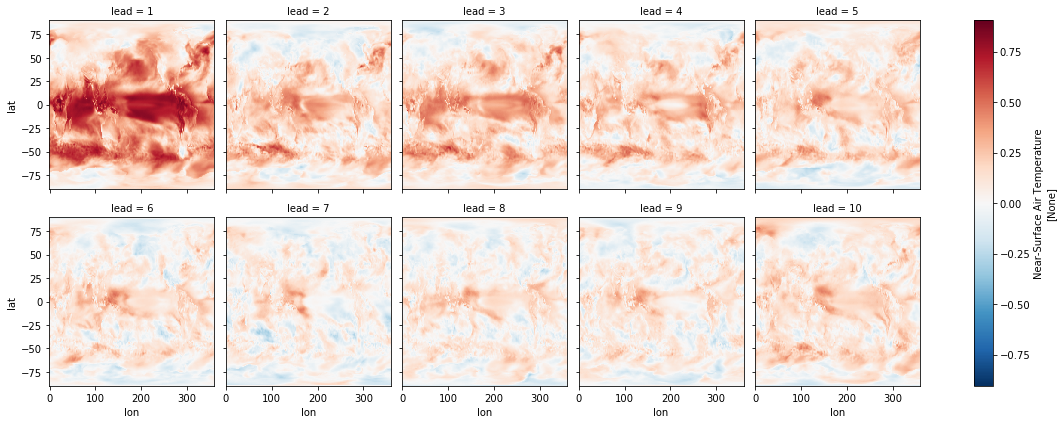

In [144]:
s.plot(col='lead',col_wrap=5)

#### intermediate saving

In [ ]:
# save to file
for key,value in dset_dict.items():
    ds = dset_dict[key].rename({
    'member_id':'member','dcpp_init_year':'init','time':'lead'})[variable].squeeze()
    model = key.split('.')[2]
    filename = f'{cmip6_post}/hind_{model}_{variable}.nc'
    print(ds.nbytes/1e9,'GB',filename)
    try:
        if not os.path.exists(filename):
            ds.to_dataset(name=variable).to_netcdf(filename)
    except:
        print(f'{filename} error')